In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel
import plotly.graph_objects as go
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import itertools
import gpytorch
import random


In [4]:
df=pd.read_excel(r"C:\Users\p3333243\OneDrive - Saint-Gobain\Desktop\Project\DoE\uncertainity\mixed_ackley.xlsx")

In [5]:
df.columns

Index(['x_cont_1', 'x_cont_2', 'x_cont_3', 'x_disc_1', 'x_disc_2', 'y'], dtype='object')

In [6]:
target='y'

X = df.drop(target, axis=1)
Y = df[target]

Y = Y.values.reshape(-1, 1)


In [7]:
input_dim=X.shape[1]

In [8]:
def get_base_kernels(input_dim):
    return {
        "RBF": lambda: gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=input_dim)),
        "Matern32": lambda: gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=input_dim)),
        "Linear": lambda: gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel(ard_num_dims=input_dim)),
        "Periodic": lambda: gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(ard_num_dims=input_dim))
    }

In [9]:
def parse_kernel(expr, kernels_dict):
    tokens = expr.split()
    kernel = kernels_dict[tokens[0]]()  
    i = 1
    while i < len(tokens):
        op = tokens[i]
        next_kernel = kernels_dict[tokens[i + 1]]()  
        if op == '+':
            kernel = kernel + next_kernel
        elif op == '*':
            kernel = kernel * next_kernel
        i += 2
    return kernel
    

In [10]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [11]:
def reset_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [12]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
import gpytorch
import random
base_kernels = get_base_kernels(input_dim)

# ---------------------------------------------------------
# Helper functions
# ---------------------------------------------------------
def reset_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

def apply_log_transform(X, Y, log_X=False, log_Y=False):
    X_trans = np.log1p(X) if log_X else X.copy()
    Y_trans = np.log1p(Y) if log_Y else Y.copy()
    return X_trans, Y_trans

def inverse_log_transform(Y, log_Y=False):
    return np.expm1(Y) if log_Y else Y

def get_kfolds(X, threshold=100, default_k=10):
    """Determine appropriate number of folds based on dataset size."""
    return len(X) if len(X) <= threshold else default_k

# ---------------------------------------------------------
# K-Fold evaluation with parallelization
# ---------------------------------------------------------
def evaluate_kernel_cv(kernel_fn, X_tensor, Y_tensor, k_folds,y_scaler,train_iters=50, seed=42, log_Y=False):

    def train_and_eval_fold(train_idx, test_idx):
        X_train, X_val = X_tensor[train_idx], X_tensor[test_idx]
        Y_train, Y_val = Y_tensor[train_idx], Y_tensor[test_idx]

        # Initialize GP
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        kernel = kernel_fn()
        model = ExactGPModel(X_train, Y_train, likelihood, kernel)

        # Train
        model.train()
        likelihood.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for i in range(train_iters):
            optimizer.zero_grad()
            output = model(X_train)
            loss = -mll(output, Y_train)
            loss.backward()
            optimizer.step()

        # Eval
        model.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            preds = model(X_val)
            mean = preds.mean
            mean_orig = y_scaler.inverse_transform(mean.numpy().reshape(-1, 1))
            mean_orig = inverse_log_transform(mean_orig, log_Y)

            Y_val_orig = y_scaler.inverse_transform(Y_val.numpy().reshape(-1, 1))
            Y_val_orig = inverse_log_transform(Y_val_orig, log_Y)

            mse = mean_squared_error(Y_val_orig, mean_orig)
            return np.sqrt(mse)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)
    # Parallelize folds
    rmses = Parallel(n_jobs=-1)(
        delayed(train_and_eval_fold)(train_idx, test_idx)
        for train_idx, test_idx in kf.split(X_tensor)
    )

    return np.mean(rmses)

# ---------------------------------------------------------
# Greedy kernel search with CV integration
# ---------------------------------------------------------
def greedy_kernel_search(
    X_train_tensor, Y_train_tensor, 
    y_scaler, base_kernels, k_folds,
    max_depth=3, train_iters=50,
    seed=42, log_Y=False
):
    results = []
    best_rmse = float('inf')
    best_model = None
    best_kernel_expr = None
    
    current_kernels = list(base_kernels.keys())
    
    for depth in range(max_depth):
        print(f"\n=== Depth {depth+1} ===")
        next_kernels = []
        
        for expr in current_kernels:
            reset_seeds(seed)
            print(f"Trying kernel: {expr}")
            kernel_fn = lambda: parse_kernel(expr, base_kernels)
            
            mean_rmse = evaluate_kernel_cv(
                kernel_fn, X_train_tensor, Y_train_tensor,k_folds,
                y_scaler=y_scaler,
                train_iters=train_iters, seed=seed, log_Y=log_Y
            )

            print(f"  CV RMSE: {mean_rmse:.4f}")
            results.append((expr, mean_rmse))

            if mean_rmse < best_rmse:
                best_rmse = mean_rmse
                best_kernel_expr = expr
        
        # Greedy expansion
        results_sorted = sorted(results, key=lambda x: x[1])
        best_expr = results_sorted[0][0]

        next_kernels = []
        for new_expr in base_kernels.keys():
            if new_expr != best_expr:
                next_kernels.extend([f"{best_expr} + {new_expr}", f"{best_expr} * {new_expr}"])
        
        current_kernels = next_kernels
    
    print(f"\n✅ Best kernel overall: {best_kernel_expr}, RMSE = {best_rmse:.4f}")
    return best_rmse, best_kernel_expr, results

# ---------------------------------------------------------
# Main driver (same as before)
# ---------------------------------------------------------
transform_configs = [
    {"name": "no_transform", "log_X": False, "log_Y": False},
    {"name": "log_input_only", "log_X": True, "log_Y": False},
    {"name": "log_output_only", "log_X": False, "log_Y": True},
    {"name": "log_input_output", "log_X": True, "log_Y": True},
]

k_folds = get_kfolds(X, threshold=100, default_k=2)
print(f"Using {k_folds}-fold cross-validation.")
results_summary = []

for cfg in transform_configs:
    print(f"\n{'='*60}")
    print(f"Running configuration: {cfg['name']}")
    print(f"{'='*60}")

    # --- Apply log transforms ---
    try:
        X_train_trans, Y_train_trans = apply_log_transform(X, Y, cfg["log_X"], cfg["log_Y"])
    except Exception as e:
        print(f"⚠️ Skipping {cfg['name']} due to transformation error: {e}")
        continue

    if not np.all(np.isfinite(X_train_trans)) or not np.all(np.isfinite(Y_train_trans)):
        print(f"⚠️ Skipping {cfg['name']} due to inf/NaN in training data.")
        continue

    # --- Scale data ---
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    X_train_scaled = x_scaler.fit_transform(X_train_trans)
    Y_train_scaled = y_scaler.fit_transform(Y_train_trans.reshape(-1, 1))

    X_train_tensor = torch.tensor(X_train_scaled).float()
    Y_train_tensor = torch.tensor(Y_train_scaled).squeeze().float()

    # --- Run greedy kernel search with K-Fold ---
    best_rmse, best_kernel_expr, all_results = greedy_kernel_search(
        X_train_tensor, Y_train_tensor,
        y_scaler, base_kernels,k_folds,
        max_depth=2, train_iters=50,
        seed=42, log_Y=cfg["log_Y"]
    )

    results_summary.append({
        "config": cfg["name"],
        "best_rmse": best_rmse,
        "best_kernel": best_kernel_expr,
        "x_scaler": x_scaler,
        "y_scaler": y_scaler
    })

# ---------------------------------------------------------
# Final Summary
# ---------------------------------------------------------
print("\n====================== FINAL SUMMARY ======================")
for res in results_summary:
    print(f"{res['config']}: RMSE = {res['best_rmse']:.4f}, Kernel = {res['best_kernel']}")


Using 2-fold cross-validation.

Running configuration: no_transform

=== Depth 1 ===
Trying kernel: RBF
  CV RMSE: 0.5928
Trying kernel: Matern32
  CV RMSE: 0.6104
Trying kernel: Linear
  CV RMSE: 3.0138
Trying kernel: Periodic
  CV RMSE: 2.1119

=== Depth 2 ===
Trying kernel: RBF + Matern32
  CV RMSE: 0.5691
Trying kernel: RBF * Matern32
  CV RMSE: 0.5886
Trying kernel: RBF + Linear
  CV RMSE: 0.5924
Trying kernel: RBF * Linear
  CV RMSE: 0.5908
Trying kernel: RBF + Periodic
  CV RMSE: 0.3343
Trying kernel: RBF * Periodic
  CV RMSE: 0.8366

✅ Best kernel overall: RBF + Periodic, RMSE = 0.3343

Running configuration: log_input_only
⚠️ Skipping log_input_only due to inf/NaN in training data.

Running configuration: log_output_only

=== Depth 1 ===
Trying kernel: RBF


C:\Users\p3333243\AppData\Local\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


  CV RMSE: 0.6358
Trying kernel: Matern32
  CV RMSE: 0.6019
Trying kernel: Linear
  CV RMSE: 3.0321
Trying kernel: Periodic
  CV RMSE: 2.0863

=== Depth 2 ===
Trying kernel: Matern32 + RBF
  CV RMSE: 0.5839
Trying kernel: Matern32 * RBF
  CV RMSE: 0.5942
Trying kernel: Matern32 + Linear
  CV RMSE: 0.6018
Trying kernel: Matern32 * Linear
  CV RMSE: 0.6427
Trying kernel: Matern32 + Periodic
  CV RMSE: 0.3625
Trying kernel: Matern32 * Periodic
  CV RMSE: 0.6301

✅ Best kernel overall: Matern32 + Periodic, RMSE = 0.3625

Running configuration: log_input_output
⚠️ Skipping log_input_output due to inf/NaN in training data.

====================== FINAL SUMMARY ======================
no_transform: RMSE = 0.3343, Kernel = RBF + Periodic
log_output_only: RMSE = 0.3625, Kernel = Matern32 + Periodic


C:\Users\p3333243\AppData\Local\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [13]:
best_result=min(results_summary, key=lambda x:x['best_rmse'])

In [14]:
# Reuse the best transform and scalers
best_x_scaler = best_result["x_scaler"]
best_y_scaler = best_result["y_scaler"]
best_kernel_expr = best_result["best_kernel"]

# Apply the same transforms and scaling to the full dataset
X_full_trans, Y_full_trans = apply_log_transform(X,Y,
                                                 log_X="input" in best_result["config"],
                                                 log_Y="output" in best_result["config"])
X_full_scaled = best_x_scaler.transform(X_full_trans)
Y_full_scaled = best_y_scaler.transform(Y_full_trans)

X_full_tensor = torch.tensor(X_full_scaled).float()
Y_full_tensor = torch.tensor(Y_full_scaled).squeeze().float()

# Create and train the final model
reset_seeds(42)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
kernel = parse_kernel(best_kernel_expr, base_kernels)
final_model = ExactGPModel(X_full_tensor, Y_full_tensor, likelihood, kernel)

final_model.train()
likelihood.train()

optimizer = torch.optim.Adam(final_model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, final_model)

train_iters = 100  
for i in range(train_iters):
    optimizer.zero_grad()
    output = final_model(X_full_tensor)
    loss = -mll(output, Y_full_tensor)
    loss.backward()
    optimizer.step()

print("✅ Final model trained successfully on full dataset!")

✅ Final model trained successfully on full dataset!


In [15]:
# PDP plot

In [16]:
import numpy as np
import pandas as pd
import torch
import gpytorch
import matplotlib.pyplot as plt

def plot_pdp_gp_ice(
    model,
    x_scaler,
    y_scaler,
    X,
    best_cfg,
    feature_names=None,
    n_points=1000
):

    assert isinstance(X, pd.DataFrame)
    if feature_names is None:
        feature_names = X.columns.tolist()

    # Detect log transformations automatically
    log_X = "log" in best_cfg and "input" in best_cfg
    log_Y = "log" in best_cfg and "output" in best_cfg
    print(f"Detected config → log_X={log_X}, log_Y={log_Y}")

    for feat in feature_names:
        # Values to sweep for current feature
        x_vals = np.linspace(X[feat].min(), X[feat].max(), n_points)
        y_means = []

        for val in x_vals:
            X_temp = X.copy()
            # Set current feature to val
            X_temp[feat] = val
            # Apply log if used during training
            X_trans = np.log1p(X_temp) if log_X else X_temp

            # Scale
            X_scaled = x_scaler.transform(X_trans)
            X_tensor = torch.tensor(X_scaled).float()

            # GP prediction
            model.eval()
            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                preds = model(X_tensor)
                y_pred_scaled = preds.mean.cpu().numpy().reshape(-1, 1)

            # Inverse scale
            y_pred = y_scaler.inverse_transform(y_pred_scaled)

            # Inverse log if needed
            if log_Y:
                y_pred = np.expm1(y_pred)

            # Average over all rows
            y_means.append(y_pred.mean())

        # Plot PDP
        plt.figure(figsize=(6, 4))
        plt.plot(x_vals, y_means, lw=2)
        plt.title(f"PDP for {feat} ({best_cfg})")
        plt.xlabel(feat)
        plt.ylabel("Predicted Output (original scale)")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


Detected config → log_X=False, log_Y=False


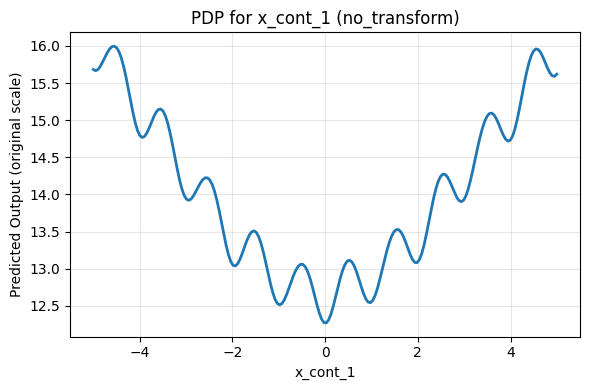

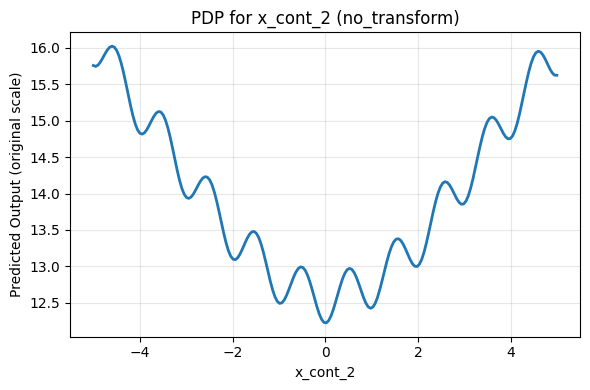

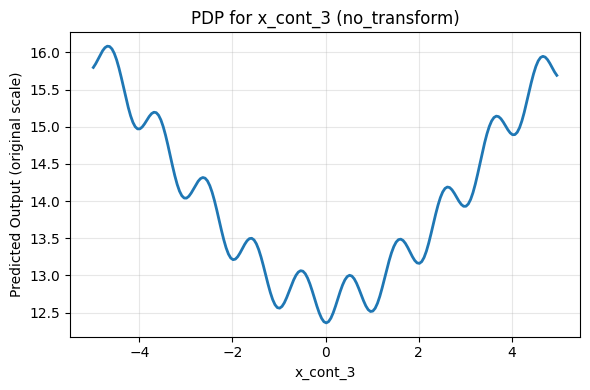

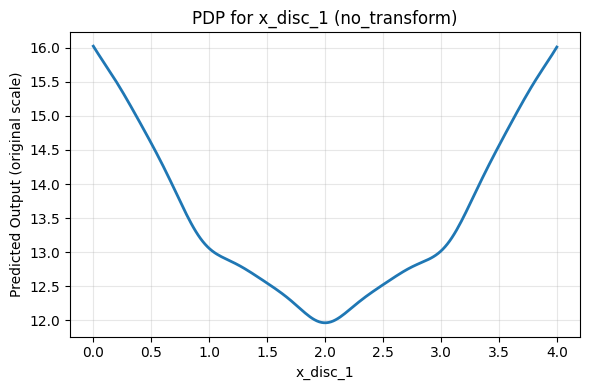

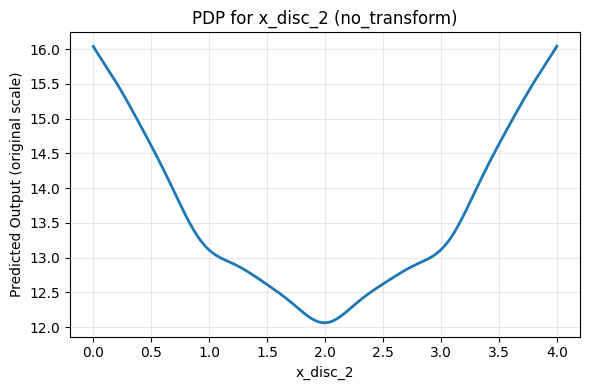

In [17]:
best_cfg = best_result['config']  

plot_pdp_gp_ice(
    model=final_model,
    x_scaler=best_result['x_scaler'],
    y_scaler=best_result['y_scaler'],
    X=X,  
    best_cfg=best_cfg,
    feature_names=X.columns.tolist(),
    n_points=200
)


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(feature_importance_df, title="GPR Feature Importance", top_n=None, figsize=(8, 5)):
    df = feature_importance_df.copy()
    if top_n is not None:
        df = df.head(top_n)

    plt.figure(figsize=figsize)
    sns.barplot(data=df, x='Influence (%)', y='Feature', palette='viridis')
    plt.title(title)
    plt.xlabel("Influence (%)")
    plt.ylabel("Feature")
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



In [19]:
def compute_gpr_feature_importance_gpytorch(model, x_scaler, y_scaler, X,best_cfg, feature_names=None, n_points=100):
 
    if isinstance(X, pd.DataFrame):
        X = X.values

    input_dim = X.shape[1]
    X_mean = X.mean(axis=0)

    if feature_names is None:
        feature_names = [f"Feature {i+1}" for i in range(input_dim)]

    importances = []
    # Detect log transformations automatically
    log_X = "log" in best_cfg and "input" in best_cfg
    log_Y = "log" in best_cfg and "output" in best_cfg
    print(f"Detected config → log_X={log_X}, log_Y={log_Y}")

    for i in range(input_dim):
        x_vals = np.linspace(X[:, i].min(), X[:, i].max(), n_points)
        X_temp = np.tile(X_mean, (n_points, 1))
        X_temp[:, i] = x_vals

        # Apply log if used during training
        X_trans = np.log1p(X_temp) if log_X else X_temp

        
        # Scale inputs for model prediction
        X_pdp_scaled = x_scaler.transform(pd.DataFrame(X_trans, columns=feature_names))

        X_tensor = torch.tensor(X_pdp_scaled).float()

        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            preds = model(X_tensor)
            y_pred_scaled = preds.mean.cpu().numpy().reshape(-1, 1)

        # Unscale predictions
        y_pred_unscaled = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        # Inverse log if needed
        if log_Y:
            y_pred_unscaled = np.expm1(y_pred_unscaled)
        # Feature importance = range of PDP values
        importance = np.ptp(y_pred_unscaled)
        importances.append(importance)

    # Normalize to % influence
    importances = np.array(importances)
    influence_percent = importances / importances.sum() * 100

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Influence (%)': influence_percent
    }).sort_values(by='Influence (%)', ascending=False)

    return feature_importance_df


In [20]:
feature_name_list=X.columns.to_list()

Detected config → log_X=False, log_Y=False


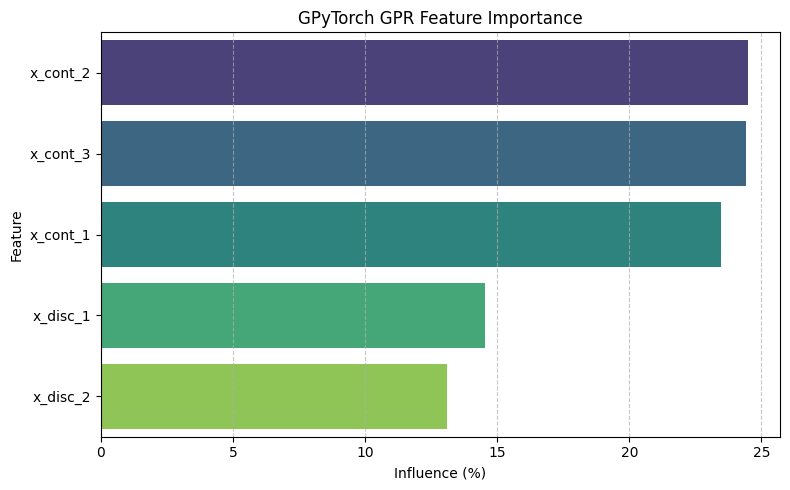

In [21]:
fi_df = compute_gpr_feature_importance_gpytorch(final_model, best_result['x_scaler'], best_result['y_scaler'], X,best_result['config'], feature_names=feature_name_list)
plot_feature_importance(fi_df, title="GPyTorch GPR Feature Importance")


In [22]:
X_cont_variable=['x_cont_1', 'x_cont_2', 'x_cont_3']
X_discont_variable=['x_disc_1', 'x_disc_2']


In [23]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm

def generate_samples(
    df,
    n_samples=10000,
    continuous_vars=None,
    discrete_vars=None,
    discrete_combo=None,
    nominal_override=None,
    noise_override=None,
    default_noise=0.1,
    domain_limits=None,
):
    """
    Generate synthetic samples for continuous variables (via truncated normal)
    and optionally fix discrete variables to a specified combination.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset
    n_samples : int
        Number of samples to generate
    continuous_vars : list
        List of continuous variable names
    discrete_vars : list
        List of discrete (categorical/numeric code) variable names
    discrete_combo : dict, optional
        e.g., {'x_disc_1': 2, 'x_disc_2': 1} — fixed values for discrete vars
    nominal_override : dict, optional
        Custom mean (nominal) values for continuous vars only
    noise_override : dict, optional
        Custom relative noise (fraction of nominal)
    default_noise : float
        Default noise fraction for continuous vars
    domain_limits : dict, optional
        {col: (min, max)} bounds; inferred from df if None
    """

    # --- Identify continuous vars automatically if not provided ---
    if continuous_vars is None:
        continuous_vars = [col for col in df.select_dtypes(include=np.number).columns]
    if discrete_vars is None:
        discrete_vars = []

    # Remove any overlap just in case
    continuous_vars = [c for c in continuous_vars if c not in discrete_vars]

    # --- Nominal and std deviation for continuous vars ---
    nominal = df[continuous_vars].mean()
    std_dev = nominal.abs() * default_noise
    std_dev = std_dev.where(nominal != 0, df[continuous_vars].std() * default_noise)

    # --- Apply overrides for continuous vars only ---
    if nominal_override:
        for col, val in nominal_override.items():
            if col in nominal:
                nominal[col] = val

    if noise_override:
        for col, val in noise_override.items():
            if col in std_dev:
                base_nominal = nominal[col]
                std_dev[col] = abs(base_nominal) * val if base_nominal != 0 else df[col].std() * val

    # --- Domain limits ---
    if domain_limits is None:
        domain_limits = {col: (df[col].min(), df[col].max()) for col in continuous_vars}

    # --- Generate continuous samples ---
    samples = {}
    for col in continuous_vars:
        mu, sigma = nominal[col], std_dev[col]
        lower, upper = domain_limits[col]
        a, b = (lower - mu) / sigma, (upper - mu) / sigma
        samples[col] = truncnorm.rvs(a, b, loc=mu, scale=sigma, size=n_samples)

    # --- Handle discrete vars ---
    for col in discrete_vars:
        if discrete_combo and col in discrete_combo:
            samples[col] = [discrete_combo[col]] * n_samples
        else:
            # Default to most frequent value if no combo given
            samples[col] = [df[col].mode().iloc[0]] * n_samples

    return pd.DataFrame(samples)


In [24]:
X_cont_variable = ['x_cont_1', 'x_cont_2', 'x_cont_3']
X_discont_variable = ['x_disc_1', 'x_disc_2']

discrete_combo = {'x_disc_1': 2, 'x_disc_2': 2}

nominal_custom = {
    'x_cont_1': -1.58933648949741,
    'x_cont_2': -3.8652647875941,
    'x_cont_3': 4.24693618278562,
}

sampled_df = generate_samples(
    df,
    n_samples=len(df) * 100,
    continuous_vars=X_cont_variable,
    discrete_vars=X_discont_variable,
    discrete_combo=discrete_combo,
    nominal_override=nominal_custom,
)


In [25]:
def mc(df,x_scaler,y_scaler,best_model,best_cfg):
    log_X = "log" in best_cfg and "input" in best_cfg
    log_Y = "log" in best_cfg and "output" in best_cfg
    print(f"Detected config → log_X={log_X}, log_Y={log_Y}")

    # Apply log if used during training
    df_trans = np.log1p(df) if log_X else df
    # Scale inputs for model prediction
    X_sim_scaled = torch.tensor(x_scaler.transform(df_trans), dtype=torch.float32)
    best_model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = best_model(X_sim_scaled)  # use model directly
        Y_sim_scaled = pred_dist.mean.numpy()
    Y_sim_unscaled = y_scaler.inverse_transform(Y_sim_scaled.reshape(-1, 1)).flatten()
    # Inverse log if needed
    if log_Y:
        Y_sim_unscaled = np.expm1(Y_sim_unscaled)
    mean_output = np.mean(Y_sim_unscaled)
    std_output = np.std(Y_sim_unscaled)

    print(f"🔍 Output Distribution:")
    print(f"Mean: {mean_output:.4f}")
    print(f"Std Dev: {std_output:.4f}")
    return Y_sim_unscaled,mean_output,std_output


In [26]:
Y_sim_unscaled,mean_output,std_output=mc(sampled_df,best_result['x_scaler'], best_result['y_scaler'],final_model,best_result['config'])

Detected config → log_X=False, log_Y=False
🔍 Output Distribution:
Mean: 11.5228
Std Dev: 0.0304


Enter threshold value:  11.5


C:\Users\p3333243\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


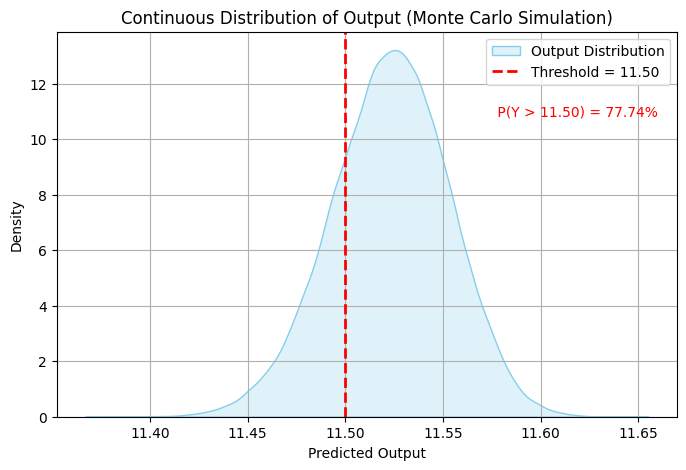

📊 Probability that output exceeds 11.50: 77.74%


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ask user for threshold
threshold = float(input("Enter threshold value: "))

# Compute probability beyond threshold
prob_beyond = np.mean(Y_sim_unscaled > threshold) * 100

# Plot smooth KDE
plt.figure(figsize=(8, 5))
sns.kdeplot(Y_sim_unscaled, fill=True, color='skyblue', label='Output Distribution')

# Add vertical line at threshold
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.2f}')

# Add annotation for probability
plt.text(
    0.97, 0.81,  # adjust vertical placement if needed
    f' P(Y > {threshold:.2f}) = {prob_beyond:.2f}%',
    transform=plt.gca().transAxes,
    fontsize=10,
    color='red',
    ha='right',
    va='top'
)

# Labels and grid
plt.xlabel("Predicted Output")
plt.ylabel("Density")
plt.title("Continuous Distribution of Output (Monte Carlo Simulation)")
plt.legend()
plt.grid(True)
plt.show()

print(f"📊 Probability that output exceeds {threshold:.2f}: {prob_beyond:.2f}%")


In [32]:
# distribution comparison
Y_overall_dist,mean_output,std_output=mc(X,best_result['x_scaler'], best_result['y_scaler'],final_model,best_result['config'])

Detected config → log_X=False, log_Y=False
🔍 Output Distribution:
Mean: 14.0211
Std Dev: 3.0265


C:\Users\p3333243\AppData\Local\anaconda3\Lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


C:\Users\p3333243\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


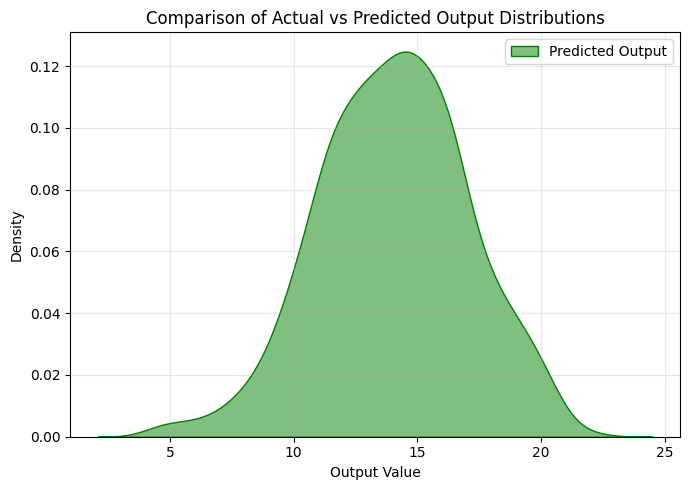

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

# Plot simulated or predicted output distribution
sns.kdeplot(Y_overall_dist, fill=True, color='Green', label='Predicted Output', alpha=0.5)

plt.title("Comparison of Actual vs Predicted Output Distributions", fontsize=12)
plt.xlabel("Output Value")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
